In [37]:
import os
import pretty_midi
import numpy as np
import random
from collections import Counter, defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Load MIDI files
midi_dir = "midi/2018"
midi_files = [os.path.join(midi_dir, f) for f in os.listdir(midi_dir) if f.endswith(".midi") or f.endswith(".mid")]
print(f"Found {len(midi_files)} MIDI files!")


Found 93 MIDI files!


# 1. Data Preprocessing


In [38]:
def estimate_chord(pitches):
    """Estimate chord from pitch classes"""
    if not pitches:
        return "N"  # No chord
    
    # Convert to pitch classes (C=0, C#=1, ..., B=11)
    pcs = sorted(set([p % 12 for p in pitches]))
    
    # Chord templates
    chord_templates = {
        # Major chords (root, 3rd, 5th)
        frozenset([0, 4, 7]): "C",
        frozenset([1, 5, 8]): "C#",
        frozenset([2, 6, 9]): "D", 
        frozenset([3, 7, 10]): "D#",
        frozenset([4, 8, 11]): "E",
        frozenset([5, 9, 0]): "F",
        frozenset([6, 10, 1]): "F#",
        frozenset([7, 11, 2]): "G",
        frozenset([8, 0, 3]): "G#",
        frozenset([9, 1, 4]): "A",
        frozenset([10, 2, 5]): "A#",
        frozenset([11, 3, 6]): "B",
        # Minor chords (root, minor 3rd, 5th)
        frozenset([0, 3, 7]): "Cm",
        frozenset([1, 4, 8]): "C#m",
        frozenset([2, 5, 9]): "Dm",
        frozenset([3, 6, 10]): "D#m", 
        frozenset([4, 7, 11]): "Em",
        frozenset([5, 8, 0]): "Fm",
        frozenset([6, 9, 1]): "F#m",
        frozenset([7, 10, 2]): "Gm",
        frozenset([8, 11, 3]): "G#m",
        frozenset([9, 0, 4]): "Am",
        frozenset([10, 1, 5]): "A#m",
        frozenset([11, 2, 6]): "Bm",
    }
    
    # Exact match
    pcs_set = frozenset(pcs)
    for template, chord_name in chord_templates.items():
        if template.issubset(pcs_set):
            return chord_name
    
    # Partial match (at least 2 notes match)
    best_match = "N"
    best_score = 0
    
    for template, chord_name in chord_templates.items():
        intersection = template.intersection(pcs_set)
        if len(intersection) >= 2:
            score = len(intersection)
            if score > best_score:
                best_score = score
                best_match = chord_name
    
    # Single note case - treat as major
    if best_match == "N" and len(pcs) >= 1:
        root_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
        return root_names[pcs[0]]
    
    return best_match


In [39]:
def extract_data(midi_files, time_step=1.0):
    """Extract chord progressions and melodies from MIDI files"""
    chord_progressions = []
    melodies = []
    
    for file_idx, midi_file in enumerate(midi_files):  # Process first 10 files
        try:
            print(f"Processing: {midi_file} ({file_idx+1})")
            midi_data = pretty_midi.PrettyMIDI(midi_file)
            
            total_time = midi_data.get_end_time()
            if total_time < 8.0:
                print(f"  -> Too short ({total_time:.1f}s), skipping")
                continue
            
            print(f"  -> Length: {total_time:.1f}s, Instruments: {len(midi_data.instruments)}")
                
            chords = []
            melody_notes = []
            
            # Analyze by time segments
            for t in np.arange(0, min(total_time, 60), time_step):
                active_notes = []
                melody_candidates = []
                
                for instrument in midi_data.instruments:
                    if instrument.is_drum:
                        continue
                        
                    for note in instrument.notes:
                        if note.start <= t + time_step and note.end >= t:
                            active_notes.append(note.pitch)
                            if note.pitch >= 48:  # C3 and above for melody
                                melody_candidates.append(note.pitch)
                
                # Chord estimation
                if len(active_notes) > 0:
                    chord = estimate_chord(active_notes)
                else:
                    chord = "N"
                chords.append(chord)
                
                # Melody note (highest pitch)
                if melody_candidates:
                    melody_note = max(melody_candidates)
                else:
                    melody_note = 60  # Default middle C
                melody_notes.append(melody_note)
            
            # Check if we have enough non-N chords
            non_n_chords = [c for c in chords if c != "N"]
            print(f"  -> Extracted chords: {len(chords)}, Non-N chords: {len(non_n_chords)}")
            
            if len(non_n_chords) > 2:
                chord_progressions.append(chords)
                melodies.append(melody_notes)
                print(f"  -> Used! Sample chords: {non_n_chords[:5]}")
            else:
                print(f"  -> Skipped due to insufficient chords")
                
        except Exception as e:
            print(f"Error processing {midi_file}: {e}")
            continue
    
    return chord_progressions, melodies

In [40]:

print("Extracting data from MIDI files...")
chord_progressions, melodies = extract_data(midi_files)

print(f"Extracted chord progressions: {len(chord_progressions)}")
print(f"Extracted melodies: {len(melodies)}")

Extracting data from MIDI files...
Processing: midi/2018/MIDI-Unprocessed_Recital5-7_MID--AUDIO_06_R1_2018_wav--3.midi (1)
  -> Length: 1461.3s, Instruments: 1
  -> Extracted chords: 60, Non-N chords: 60
  -> Used! Sample chords: ['C#', 'C#', 'C#', 'A', 'E']
Processing: midi/2018/MIDI-Unprocessed_Recital9-11_MID--AUDIO_09_R1_2018_wav--4.midi (2)
  -> Length: 270.7s, Instruments: 1
  -> Extracted chords: 60, Non-N chords: 60
  -> Used! Sample chords: ['C#', 'C#', 'A#m', 'A#m', 'A#m']
Processing: midi/2018/MIDI-Unprocessed_Recital16_MID--AUDIO_16_R1_2018_wav--3.midi (3)
  -> Length: 251.7s, Instruments: 1
  -> Extracted chords: 60, Non-N chords: 55
  -> Used! Sample chords: ['D', 'D', 'D', 'A#', 'A#']
Processing: midi/2018/MIDI-Unprocessed_Recital5-7_MID--AUDIO_07_R1_2018_wav--3.midi (4)
  -> Length: 294.1s, Instruments: 1
  -> Extracted chords: 60, Non-N chords: 60
  -> Used! Sample chords: ['F#', 'Bm', 'D', 'D', 'Bm']
Processing: midi/2018/MIDI-Unprocessed_Schubert10-12_MID--AUDIO_20_R

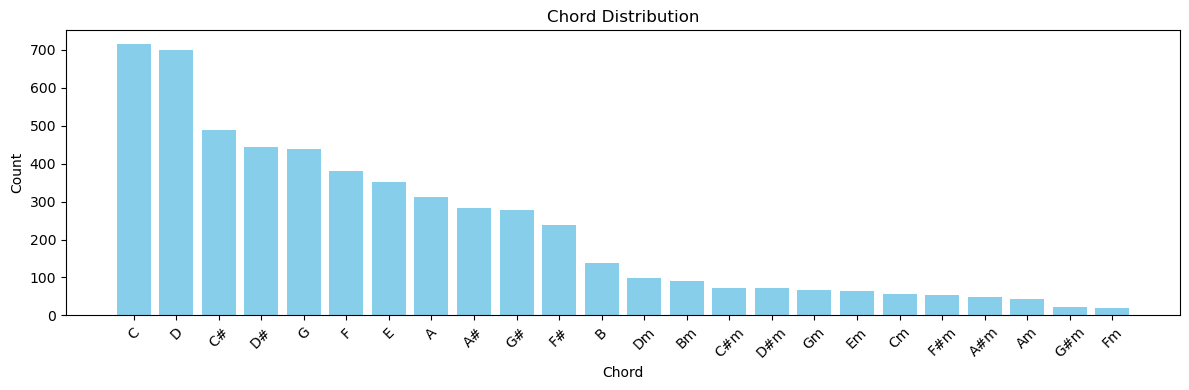

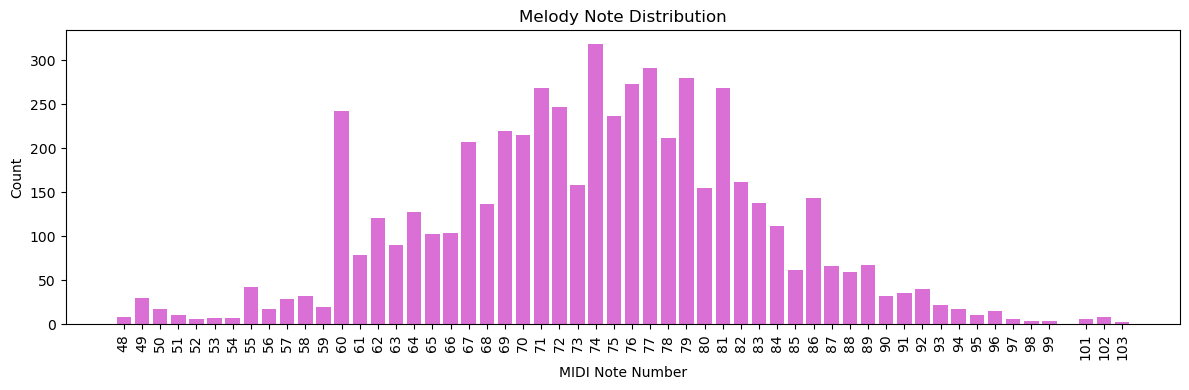

In [ ]:
# === Distribution Visualization ===
import matplotlib.pyplot as plt
from collections import Counter

# Flatten all chords and melody notes
all_chords = [c for progression in chord_progressions for c in progression if c != "N"]
all_notes = [n for melody in melodies for n in melody]

# chord distribution visualization
def plot_chord_distribution(chords):
    chord_counts = Counter(chords)
    sorted_items = sorted(chord_counts.items(), key=lambda x: x[1], reverse=True)
    labels, values = zip(*sorted_items)

    plt.figure(figsize=(12, 4))
    plt.bar(labels, values, color='skyblue')
    plt.title("Chord Distribution")
    plt.xlabel("Chord")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# melody note distribution visualization
def plot_note_distribution(notes):
    note_counts = Counter(notes)
    labels = sorted(note_counts.keys())
    values = [note_counts[k] for k in labels]

    plt.figure(figsize=(12, 4))
    plt.bar(labels, values, color='orchid')
    plt.title("Melody Note Distribution")
    plt.xlabel("MIDI Note Number")
    plt.ylabel("Count")
    plt.xticks(labels, rotation=90)
    plt.tight_layout()
    plt.show()

plot_chord_distribution(all_chords)
plot_note_distribution(all_notes)


In [41]:

# Create vocabularies
all_chords = []
all_notes = []

for progression in chord_progressions:
    all_chords.extend(progression)

for melody in melodies:
    all_notes.extend(melody)

chord_vocab = sorted(list(set(all_chords)))
note_range = range(48, 84)  # C3 to B5
note_vocab = list(note_range)

chord2idx = {chord: i for i, chord in enumerate(chord_vocab)}
idx2chord = {i: chord for chord, i in chord2idx.items()}
note2idx = {note: i for i, note in enumerate(note_vocab)}
idx2note = {i: note for note, i in note2idx.items()}

print(f"Chord vocabulary size: {len(chord_vocab)}")
print(f"Main chords: {chord_vocab}")
print(f"Note vocabulary size: {len(note_vocab)}")

Chord vocabulary size: 25
Main chords: ['A', 'A#', 'A#m', 'Am', 'B', 'Bm', 'C', 'C#', 'C#m', 'Cm', 'D', 'D#', 'D#m', 'Dm', 'E', 'Em', 'F', 'F#', 'F#m', 'Fm', 'G', 'G#', 'G#m', 'Gm', 'N']
Note vocabulary size: 36


# Markov Chain (Chord Progression)

In [42]:
class ChordMarkovChain:
    def __init__(self, order=2):
        self.order = order
        self.transitions = defaultdict(list)
        self.start_states = []
    
    def train(self, chord_progressions):
        for progression in chord_progressions:
            if len(progression) <= self.order:
                continue
                
            # Save start states
            self.start_states.append(tuple(progression[:self.order]))
            
            # Learn transition probabilities
            for i in range(len(progression) - self.order):
                current_state = tuple(progression[i:i+self.order])
                next_chord = progression[i+self.order]
                self.transitions[current_state].append(next_chord)
    
    def generate(self, length=8):
        if not self.start_states:
            return []
            
        # Choose random start state
        current_state = random.choice(self.start_states)
        result = list(current_state)
        
        for _ in range(length - self.order):
            if current_state in self.transitions and self.transitions[current_state]:
                next_chord = random.choice(self.transitions[current_state])
                result.append(next_chord)
                current_state = tuple(result[-self.order:])
            else:
                # Backoff to shorter context
                if len(result) > 1:
                    current_state = tuple(result[-1:])
                    if current_state in self.transitions:
                        next_chord = random.choice(self.transitions[current_state])
                        result.append(next_chord)
                    else:
                        next_chord = random.choice(chord_vocab)
                        result.append(next_chord)
                else:
                    break
        
        return result

In [43]:
# Train Markov chain
print("Training Markov chain...")
chord_markov = ChordMarkovChain(order=2)
chord_markov.train(chord_progressions)

# Test generation
test_progression = chord_markov.generate(8)
print(f"Generated chord progression: {test_progression}")

Training Markov chain...
Generated chord progression: ['G', 'A#', 'F', 'A#', 'A#', 'A#', 'F', 'A#']


# RNN (Melody Generation)

In [44]:
class MelodyDataset(Dataset):
    def __init__(self, melodies, note2idx, sequence_length=8):
        self.data = []
        self.sequence_length = sequence_length
        
        for melody in melodies:
            if len(melody) < sequence_length + 1:
                continue
                
            for i in range(len(melody) - sequence_length):
                seq = melody[i:i+sequence_length]
                target = melody[i+sequence_length]
                
                note_seq = [note2idx.get(note, 0) for note in seq]
                target_note = note2idx.get(target, 0)
                
                self.data.append((note_seq, target_note))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        note_seq, target = self.data[idx]
        return (torch.tensor(note_seq), torch.tensor(target))

class MelodyRNN(nn.Module):
    def __init__(self, note_vocab_size, embedding_dim=64, hidden_size=128, num_layers=2):
        super(MelodyRNN, self).__init__()
        
        self.note_embedding = nn.Embedding(note_vocab_size, embedding_dim)
        
        self.rnn = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        
        self.output_layer = nn.Linear(hidden_size, note_vocab_size)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, note_seq):
        note_emb = self.note_embedding(note_seq)
        
        # Pass through RNN
        rnn_out, _ = self.rnn(note_emb)
        
        # Use last time step output
        last_output = rnn_out[:, -1, :]
        output = self.dropout(last_output)
        output = self.output_layer(output)
        
        return output

# Create dataset
print("Creating RNN dataset...")
dataset = MelodyDataset(melodies, note2idx, sequence_length=8)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"RNN training data size: {len(dataset)}")

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = MelodyRNN(
    note_vocab_size=len(note_vocab),
    embedding_dim=64,
    hidden_size=128,
    num_layers=2
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Creating RNN dataset...
RNN training data size: 4836
Using device: cpu


# Train RNN

In [45]:
def train_model(model, dataloader, epochs=30):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (note_seq, target) in enumerate(dataloader):
            note_seq = note_seq.to(device)
            target = target.to(device)
            
            optimizer.zero_grad()
            output = model(note_seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")
    
    return losses

Starting RNN model training...
Epoch 0/30, Loss: 2.9514
Epoch 10/30, Loss: 1.7993
Epoch 20/30, Loss: 1.0788


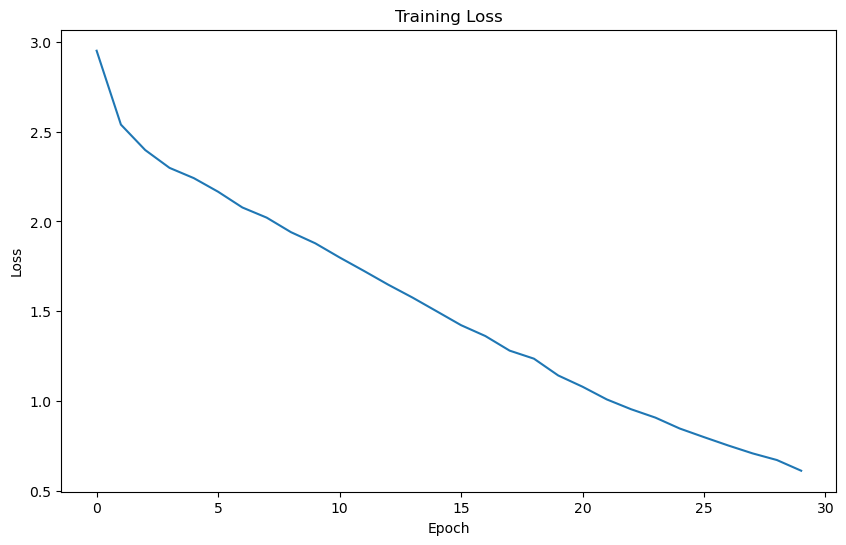

In [46]:


print("Starting RNN model training...")
losses = train_model(model, dataloader, epochs=30)
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


#  Music Generation

In [47]:

def generate_melody(model, length=32, sequence_length=8):
    """Generate melody using trained RNN"""
    model.eval()
    
    # 
    start_idx = random.randint(0, len(melodies) - 1)
    melody = melodies[start_idx]
    
    while len(melody) < sequence_length:
        start_idx = random.randint(0, len(melodies) - 1)
        melody = melodies[start_idx]

    start_pos = random.randint(0, len(melody) - sequence_length)
    generated = melody[start_pos:start_pos + sequence_length]
    
    with torch.no_grad():
        for _ in range(length - sequence_length):
            current_seq = [note2idx.get(note, 0) for note in generated[-sequence_length:]]
            note_tensor = torch.tensor([current_seq]).to(device)
            
            output = model(note_tensor)
            predicted_note_idx = torch.argmax(output, dim=1).item()
            predicted_note = idx2note.get(predicted_note_idx, 60)
            
            generated.append(predicted_note)
    
    return generated

In [48]:
def get_chord_notes(chord_name, octave=4):
    """Get MIDI note numbers for chord name"""
    root_notes = {
        'C': 0, 'C#': 1, 'D': 2, 'D#': 3, 'E': 4, 'F': 5,
        'F#': 6, 'G': 7, 'G#': 8, 'A': 9, 'A#': 10, 'B': 11
    }
    
    if chord_name == "N":
        return []
    
    # Find root note
    if chord_name.endswith('m'):
        root = chord_name[:-1]
        is_minor = True
    else:
        root = chord_name
        is_minor = False
    
    if root not in root_notes:
        return [60]  # Default
    
    root_pitch = root_notes[root] + octave * 12
    
    if is_minor:
        # Minor chord: root, minor 3rd, perfect 5th
        return [root_pitch, root_pitch + 3, root_pitch + 7]
    else:
        # Major chord: root, major 3rd, perfect 5th
        return [root_pitch, root_pitch + 4, root_pitch + 7]

In [49]:
def create_midi_file(chord_progression, melody, filename="generated_music.mid", tempo=120):
    """Create MIDI file from chord progression and melody"""
    midi_data = pretty_midi.PrettyMIDI(initial_tempo=tempo)
    
    # Chord track
    chord_instrument = pretty_midi.Instrument(program=0)  # Piano
    
    # Melody track  
    melody_instrument = pretty_midi.Instrument(program=0)  # Piano
    
    beat_duration = 60.0 / tempo
    chord_duration = beat_duration * 4  # 4 beats per chord
    note_duration = beat_duration  # 1 beat per note
    
    # Add chords
    for i, chord_name in enumerate(chord_progression):
        if chord_name == "N":
            continue
            
        start_time = i * chord_duration
        
        # Add chord notes
        chord_notes = get_chord_notes(chord_name)
        for note_pitch in chord_notes:
            note = pretty_midi.Note(
                velocity=60,
                pitch=note_pitch,
                start=start_time,
                end=start_time + chord_duration
            )
            chord_instrument.notes.append(note)
    
    # Add melody
    for i, note_pitch in enumerate(melody):
        start_time = i * note_duration
        note = pretty_midi.Note(
            velocity=80,
            pitch=note_pitch,
            start=start_time,
            end=start_time + note_duration
        )
        melody_instrument.notes.append(note)
    
    midi_data.instruments.append(chord_instrument)
    midi_data.instruments.append(melody_instrument)
    
    # Save file
    midi_data.write(filename)
    print(f"MIDI file saved: {filename}")

# Final Music Generation

In [50]:

print("\n=== Starting Music Generation ===")

# 1. Generate chord progression with Markov chain (8 chords)
generated_chord_progression = chord_markov.generate(8)
print(f"Generated chord progression: {generated_chord_progression}")

# 2. Generate melody with RNN (32 notes - 4 per chord)
if len(dataset) > 0:
    generated_melody = generate_melody(model, length=32)
    print(f"Generated melody length: {len(generated_melody)}")
    print(f"Sample melody: {generated_melody[:10]}")

# 3. Create MIDI file
create_midi_file(generated_chord_progression, generated_melody, "symbolic_unconditioned.mid")

print("\n=== Generation Complete ===")
print(f"Generated file: symbolic_unconditioned.mid")
print(f"Chord progression: {' -> '.join(generated_chord_progression)}")
print(f"Total melody notes: {len(generated_melody)} (4 notes per chord)")



=== Starting Music Generation ===
Generated chord progression: ['A#', 'D#', 'D#', 'Cm', 'G', 'Cm', 'G', 'Cm']
Generated melody length: 32
Sample melody: [63, 75, 67, 67, 67, 68, 70, 71, 68, 80]
MIDI file saved: symbolic_unconditioned.mid

=== Generation Complete ===
Generated file: symbolic_unconditioned.mid
Chord progression: A# -> D# -> D# -> Cm -> G -> Cm -> G -> Cm
Total melody notes: 32 (4 notes per chord)


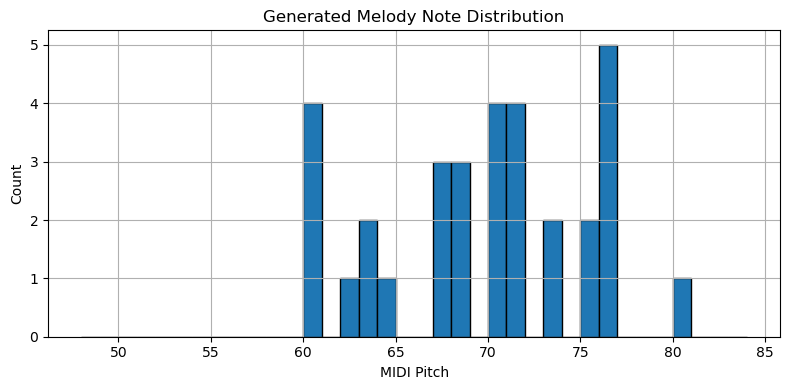

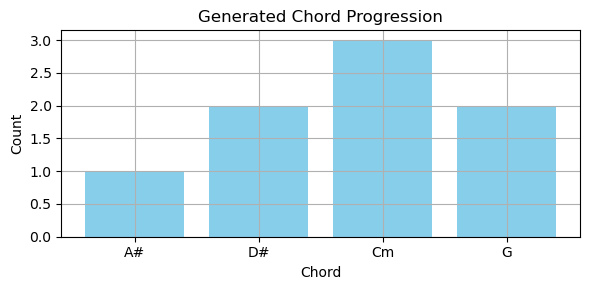

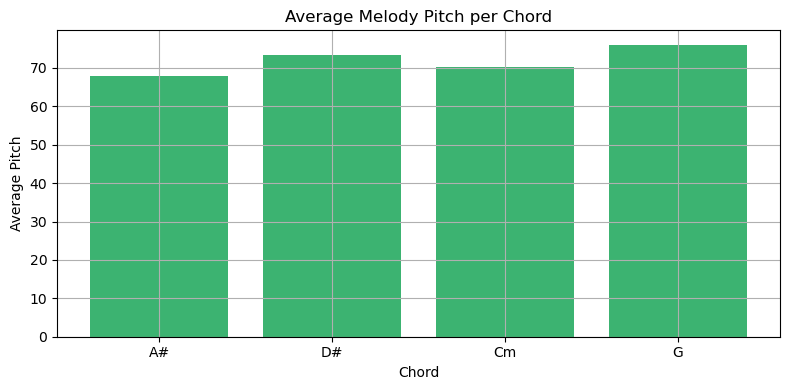

In [52]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# ------------------------------
# Plot 1: Melody Note Distribution
# ------------------------------
plt.figure(figsize=(8, 4))
plt.hist(generated_melody, bins=range(48, 85), edgecolor='black')
plt.title("Generated Melody Note Distribution")
plt.xlabel("MIDI Pitch")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("generated_melody_distribution.png")
plt.show()

# ------------------------------
# Plot 2: Chord Occurrence in Generated Progression
# ------------------------------
chord_counts = Counter(generated_chord_progression)
plt.figure(figsize=(6, 3))
plt.bar(chord_counts.keys(), chord_counts.values(), color='skyblue')
plt.title("Generated Chord Progression")
plt.xlabel("Chord")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("generated_chord_distribution.png")
plt.show()

# ------------------------------
# (Optional) Plot 3: Avg Melody Pitch per Chord
# ------------------------------
avg_pitches = [np.mean(generated_melody[i*4:(i+1)*4]) for i in range(8)]

plt.figure(figsize=(8, 4))
plt.bar(generated_chord_progression, avg_pitches, color='mediumseagreen')
plt.title("Average Melody Pitch per Chord")
plt.xlabel("Chord")
plt.ylabel("Average Pitch")
plt.grid(True)
plt.tight_layout()
plt.savefig("avg_pitch_per_chord.png")
plt.show()
